# 0.0 Imports

In [175]:
import math
import numpy as np
import pandas as pd
import random
import json
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime as dt
import requests


from scipy import stats
#from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



warnings.filterwarnings( 'ignore' )


# 0.2 Load Data

In [176]:
df_raw = pd.read_csv('C:/Users/Pamela.magalhaes/Documents/Estudos/pa004/train.csv', low_memory=False)

In [177]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0. DESCRICAO DOS DADOS

In [178]:
df_raw.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [179]:
df_raw.sample()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
349987,349988,Male,61,1,28.0,1,1-2 Year,No,30197.0,124.0,79,0


In [180]:
df1 = df_raw.copy()

In [181]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore (x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new

In [182]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [183]:
df1['vehicle_age'].drop_duplicates()

0    > 2 Years
1     1-2 Year
3     < 1 Year
Name: vehicle_age, dtype: object

## 1.2. Data Dimensions

In [184]:
df1.shape

(381109, 12)

## 1.3. Data types

In [185]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA's

In [186]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Changes

In [187]:
#vehicle_age

age_map = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}

df1['vehicle_age'] = df1['vehicle_age'].map(age_map)




In [188]:
df1.sample(5).T

,168645,379914,36475,230754,164883
id,168646,379915,36476,230755,164884
gender,Male,Male,Male,Female,Male
age,57,32,45,46,42
driving_license,1,1,1,1,1
region_code,28.0,30.0,28.0,28.0,0.0
previously_insured,0,1,0,1,0
vehicle_age,1,0,1,1,1
vehicle_damage,Yes,No,Yes,No,Yes
annual_premium,38711.0,2630.0,50808.0,36867.0,2630.0
policy_sales_channel,31.0,152.0,26.0,26.0,124.0


## 1.6. Change Types

In [189]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age               int64
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [190]:
# Convertendo de float para int
df1['region_code'] = df1['region_code'].astype(int)
df1['annual_premium'] = df1['annual_premium'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)


In [191]:
#Verificando correcoes
df1.dtypes

id                       int64
gender                  object
age                      int64
driving_license          int64
region_code              int32
previously_insured       int64
vehicle_age              int64
vehicle_damage          object
annual_premium           int32
policy_sales_channel     int32
vintage                  int64
response                 int64
dtype: object

## 1.7. Descriptive Statistical

In [192]:
num_attributes = df1.select_dtypes (include = ['int64','int32'])
cat_attributes = df1.select_dtypes (exclude = ['int64','int32'])

In [193]:
#Verificando
num_attributes.sample(2)

,id,age,driving_license,region_code,previously_insured,vehicle_age,annual_premium,policy_sales_channel,vintage,response
115319,115320,28,1,47,0,0,2630,151,197,0
216176,216177,30,1,36,1,0,32285,152,257,0


In [194]:
#Verificando
cat_attributes.sample(2)

,gender,vehicle_damage
54764,Female,No
21396,Male,Yes


### 1.7.1 Numerical Attributes

In [195]:
#Central Tendency - Mean and Median
ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () )).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis () )).T

#Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,vehicle_age,0.0,2.0,2.0,0.609616,1.0,0.567439,2.528959e-01,-0.792253
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
8,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
9,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


<Axes: xlabel='response', ylabel='Density'>

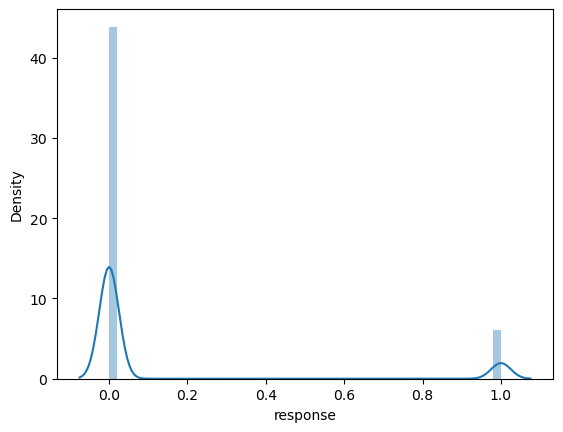

In [209]:
sns.distplot (df1['response'])

<Axes: xlabel='driving_license', ylabel='Density'>

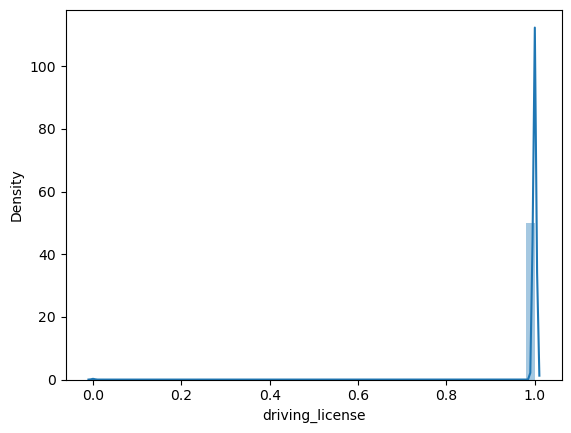

In [85]:
sns.distplot (df1['driving_license'])

### 1.7.2 Categorical Attributes

In [196]:
cat_attributes.apply (lambda x: x.unique().shape[0])

gender            2
vehicle_damage    2
dtype: int64

<Axes: xlabel='vehicle_damage', ylabel='response'>

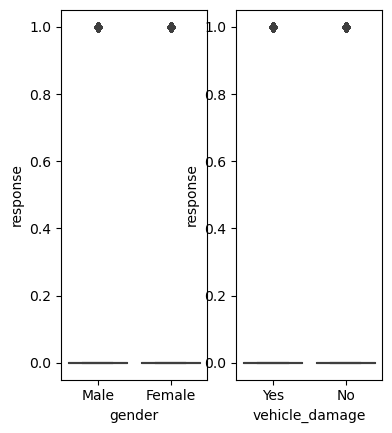

In [208]:
plt.subplot(1,3,1)
sns.boxplot (x='gender', y='response',data=df1)

plt.subplot(1,3,2)
sns.boxplot (x='vehicle_damage', y='response',data=df1)


# 2.0. FEATURE ENGENEERING

In [197]:
df2 = df1.copy ()

## 2.1 Mapa mental de hipóteses

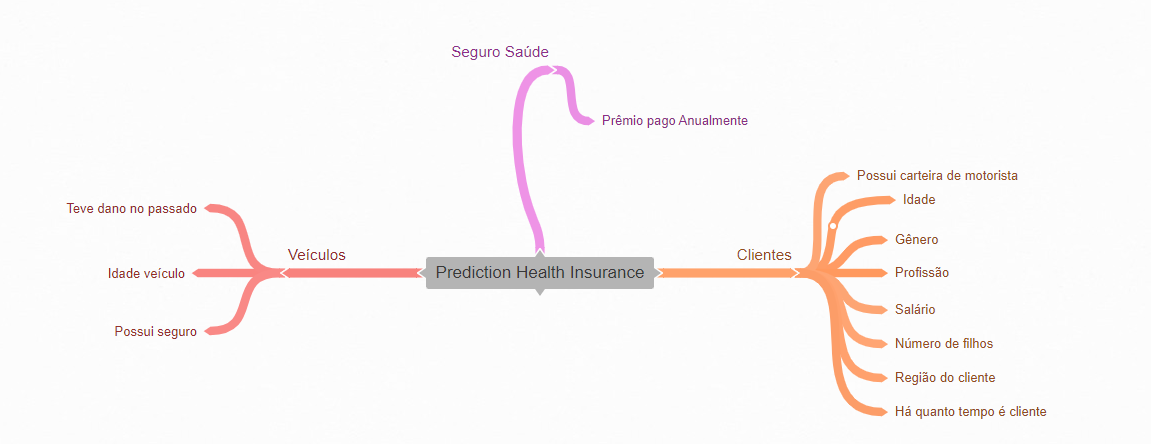

In [90]:
Image ('C:/Users/Pamela.magalhaes/Documents/Estudos/pa004/mapa_hipoteses_pa004.png')

## 2.2 Criação das hipóteses

#### 2.2.1 Hipóteses Clientes

**1.** Clientes com carteira de motorista deveriam aderir mais ao seguro de carro.

**2.** Clientes com mais idade deveriam aderir mais ao seguro de carro.

**3.** Clientes do gênero feminino deveriam aderir mais ao seguro de carro.

**4.** Clientes com salário maior deveriam aderir mais ao seguro de carro.

**5.** Clientes com menos filhos deveriam aderir mais ao seguro de carro.

**6.** Clientes que são clientes há mais tempo deveriam aderir mais ao seguro de carro.

#### 2.2.2 Hipóteses Veículos

**1.** Clientes que possuem carro que teve dano no passado deveriam aderir mais ao seguro de carro.

**2.** Clientes que possuem carros mais novos deveriam aderir mais ao seguro de carro.

**3.** Clientes que já possuem seguro de automóvel deveriam aderir renovar o seguro.

#### 2.2.3 Seguro Saúde

**1.** Clientes que pagam prêmios maiores deveriam aderir mais ao seguro de carro.

### 2.3 Lista Final das hipóteses (Hipóteses que temos dados para comprovar)

**1.** Clientes com carteira de motorista deveriam aderir mais ao seguro de carro.

**2.** Clientes com mais idade deveriam aderir mais ao seguro de carro.

**3.** Clientes do gênero feminino deveriam aderir mais ao seguro de carro.

**4.** Clientes que são clientes há mais tempo deveriam aderir mais ao seguro de carro.

**5.** Clientes que possuem carro que teve dano no passado deveriam aderir mais ao seguro de carro.

**6.** Clientes que possuem carros mais novos deveriam aderir mais ao seguro de carro.

**7.** Clientes que já possuem seguro de automóvel deveriam aderir renovar o seguro.

**8.** Clientes que pagam prêmios maiores deveriam aderir mais ao seguro de carro.

### 2.4 Feature Engineering

In [198]:
#Age

df2['age'] = df2['age'].apply(lambda x: 'jovem' if x >= 20 else 'adulto' if 35 <= x <= 60 else 'idoso')

#Gender
df2['gender'] = df2['gender'].apply(lambda x: 0 if x == 'Female' else 1 if x == 'Male' else x)

#Vintage (há quantos dias é cliente)
df2 ['vintage'] = df2 ['vintage'].apply (lambda x: 'cliente_novo' if x <= 90  else 'cliente_antigo' if x >= 91  else x)

#vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1 if x == 'Yes' else x)

#vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'carro_zero' if x < 1  else 'semi_novo' if x >= 1  else x)

#annual_premium
df2 ['annual_premium'] = df2 ['annual_premium'].apply (lambda x: 'premio_baixo' if x < 10000  
                                                                                else 'premio_medio' if 10000 >= x <= 30000
                                                                                else 'premio_alto')



In [199]:
#Verificando
df2.head().T

,0,1,2,3,4
id,1,2,3,4,5
gender,1,1,1,1,0
age,jovem,jovem,jovem,jovem,jovem
driving_license,1,1,1,1,1
region_code,28,3,28,11,41
previously_insured,0,0,0,1,1
vehicle_age,semi_novo,semi_novo,semi_novo,carro_zero,carro_zero
vehicle_damage,1,0,1,0,0
annual_premium,premio_alto,premio_alto,premio_alto,premio_alto,premio_alto
policy_sales_channel,26,26,26,152,152


# 3.0. FILTRAGEM DE VARIAVEIS

In [200]:
df3 = df2.copy()

In [201]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,1,jovem,1,28,0,semi_novo,1,premio_alto,26,cliente_antigo,1
1,2,1,jovem,1,3,0,semi_novo,0,premio_alto,26,cliente_antigo,0
2,3,1,jovem,1,28,0,semi_novo,1,premio_alto,26,cliente_novo,1
3,4,1,jovem,1,11,1,carro_zero,0,premio_alto,152,cliente_antigo,0
4,5,0,jovem,1,41,1,carro_zero,0,premio_alto,152,cliente_novo,0


## 3.1 Filtragem das linhas

In [202]:
df3 = df3[(df3 ['driving_license'] == 1) & (df3['previously_insured'] == 0)]

## 3.2 Seleção das colunas

In [203]:
cols_drop = ['policy_sales_channel']

In [204]:
df3 = df3.drop (cols_drop, axis=1)

In [205]:
#Verificando se as colunas foram excluidas
df3.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'vintage', 'response'],
      dtype='object')

# 4.0. EDA - ANALISE EXPLORATORIA DOS DADOS

In [206]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

<Axes: xlabel='response'>

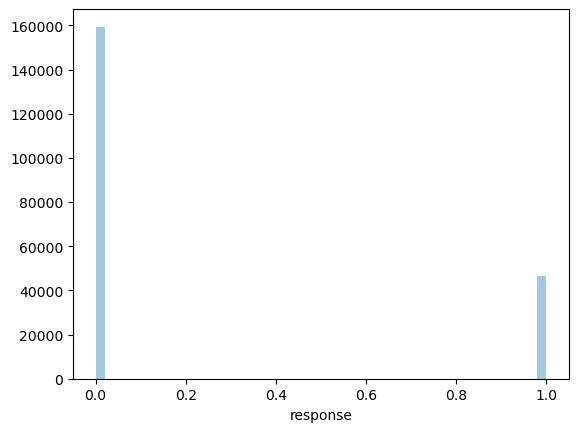

In [207]:
sns.distplot (df4['response'], kde=False)

### 4.1.2 Numerical Variable

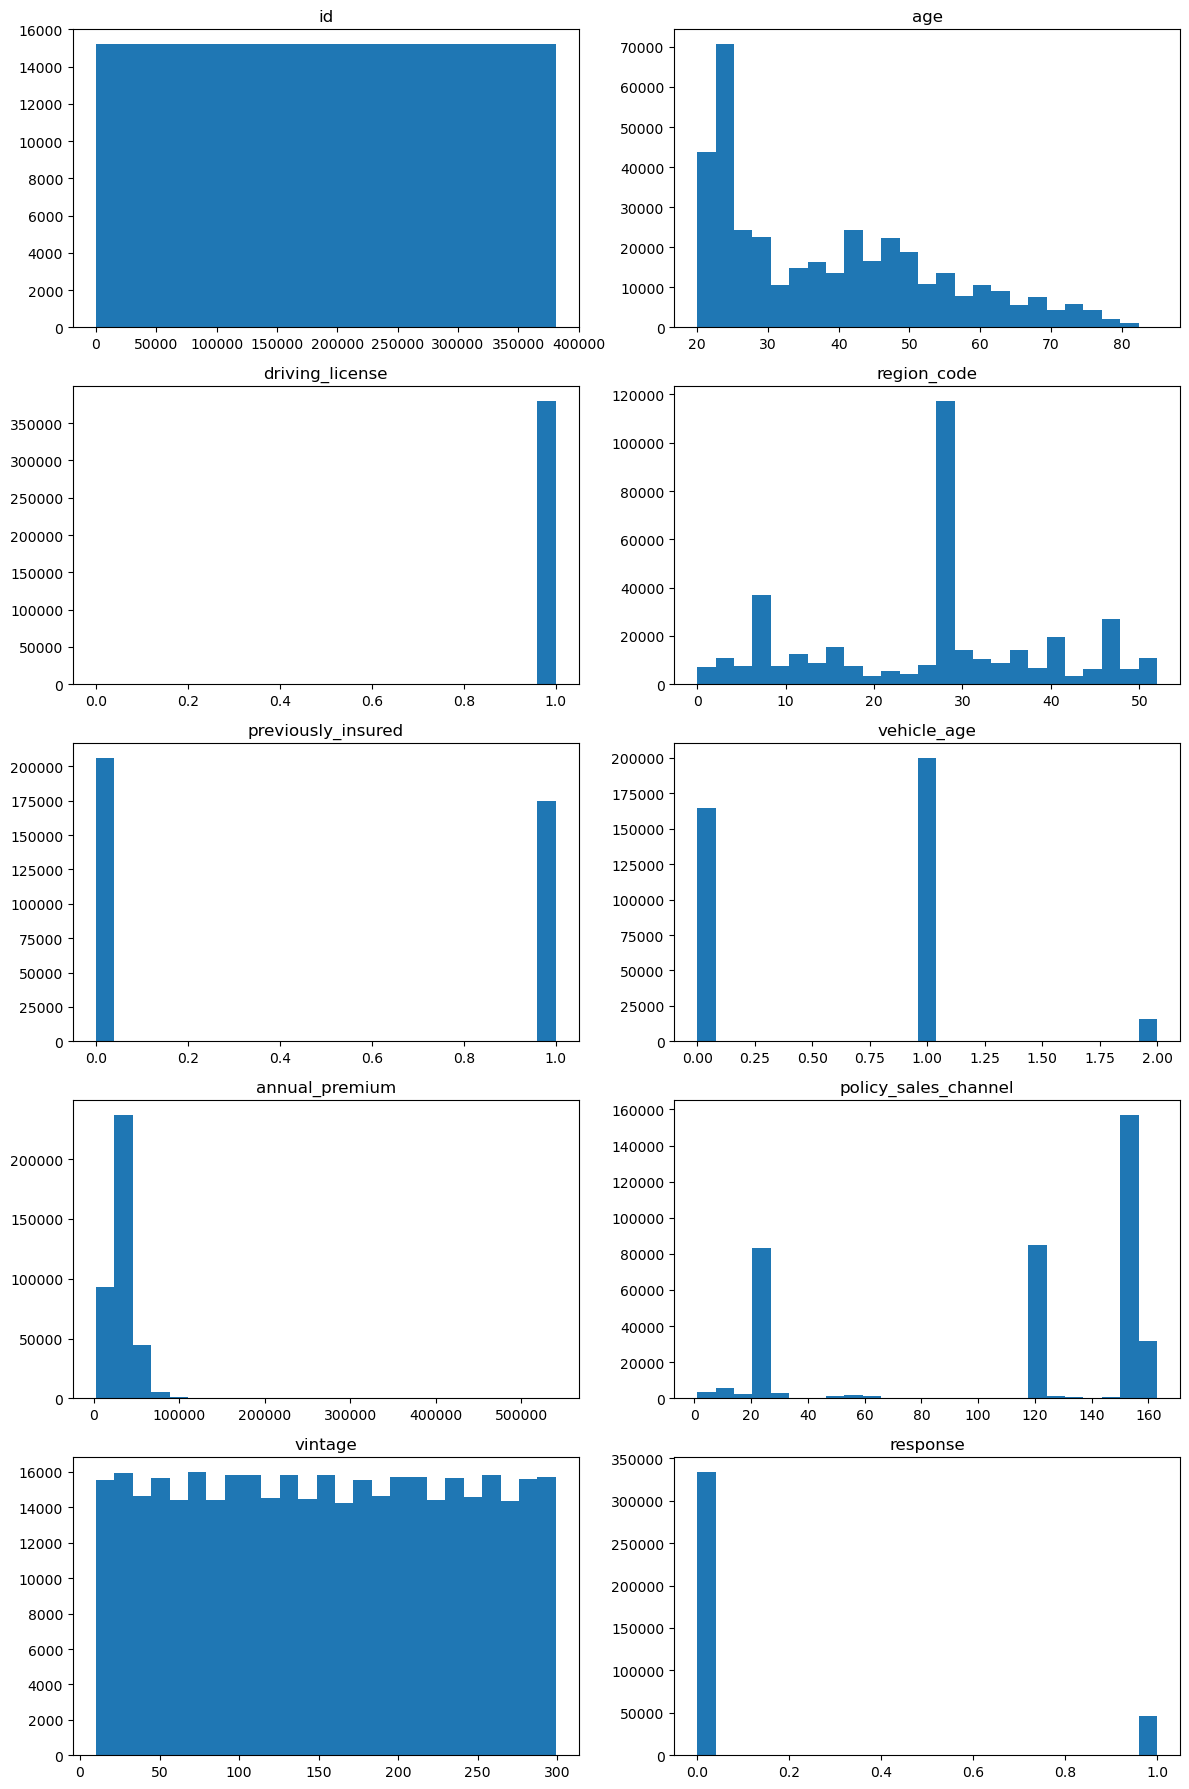

In [220]:
fig, axs = plt.subplots(5, 2, figsize=(12, 18))

# Iterando sobre as colunas e plotando o histograma em cada subplot
for i, col in enumerate(num_attributes.columns):
    ax = axs[i // 2, i % 2]  # Obtendo o subplot correspondente
    ax.hist(num_attributes[col], bins=25)  # Plotando o histograma para a coluna atual
    ax.set_title(col)  # Definindo o título do subplot com o nome da coluna

plt.tight_layout()  # Ajustando o espaçamento entre os subplots
plt.show()

### 4.1.3 Categorical Variable

In [221]:
cat_attributes.head()

,gender,vehicle_damage
0,Male,Yes
1,Male,No
2,Male,Yes
3,Male,No
4,Female,No


<Axes: >

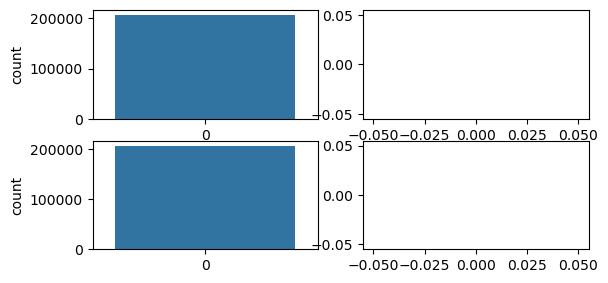

In [222]:
#gender
plt.subplot(3,2,1)
sns.countplot(df4['gender'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['gender'] == 'Male']['response'], label='Male', shade=True)
sns.kdeplot(df4[df4['gender'] == 'Female']['response'], label='Female', shade=True)


#vehicle_damage
plt.subplot(3,2,3)
sns.countplot(df4['vehicle_damage'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['vehicle_damage'] == 'Yes']['response'], label='Yes', shade=True)
sns.kdeplot(df4[df4['vehicle_damage'] == 'No']['response'], label='No', shade=True)


## 4.2 Analise Bivariada

### H1 - Clientes com carteira de motorista deveriam aderir mais ao seguro de carro.
**False** Clientes com carteira de motorista não necessariamente se interessam por aderir seguro de carro.

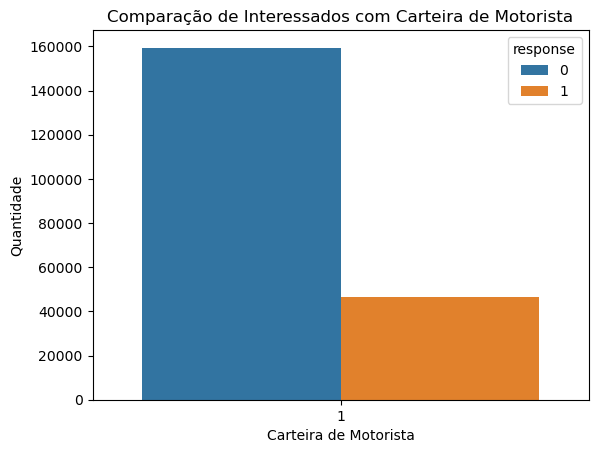

In [224]:
sns.countplot(x='driving_license', hue='response', data=df4)
plt.xlabel('Carteira de Motorista')
plt.ylabel('Quantidade')
plt.title('Comparação de Interessados com Carteira de Motorista')
plt.show()

### H2 - Clientes com mais idade deveriam aderir mais ao seguro de carro.
**False** Clientes com mais idade não aderem mais ao seguro de carro, quanto os jovens aderem.

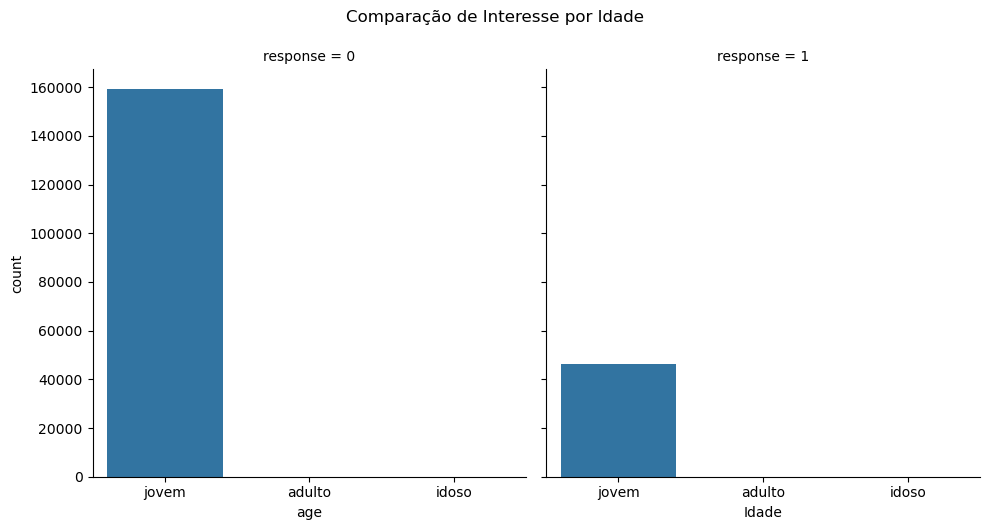

In [226]:
sns.catplot(x='age', col='response', kind='count', data=df4, order=['jovem', 'adulto', 'idoso'])
plt.xlabel('Idade')
plt.ylabel('Quantidade')
plt.suptitle('Comparação de Interesse por Idade', y=1.05)
plt.show()


### H3 - Clientes do gênero feminino deveriam aderir mais ao seguro de carro.
**True** 

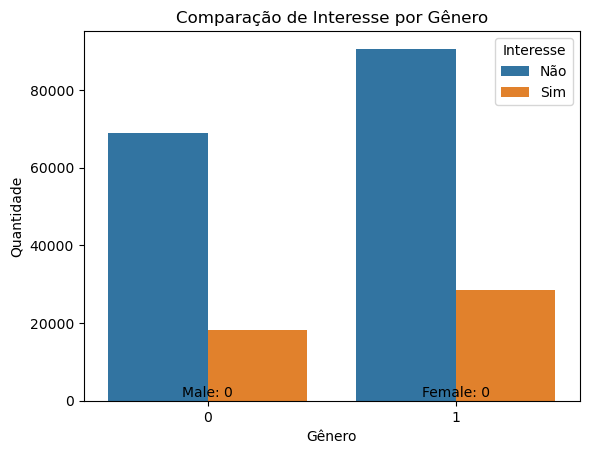

In [237]:
sns.countplot(x='gender', hue='response', data=df4)
plt.xlabel('Gênero')
plt.ylabel('Quantidade')
plt.title('Comparação de Interesse por Gênero')
plt.legend(title='Interesse', labels=['Não', 'Sim'])

# Adicionar anotações para especificar Male e Female
total_female = df4[df4['gender'] == 'Female'].shape[0]
total_male = df4[df4['gender'] == 'Male'].shape[0]
plt.annotate(f'Male: {total_male}', xy=(0, total_male), xytext=(0, total_male + 1000),
             ha='center', color='black')
plt.annotate(f'Female: {total_female}', xy=(1, total_female), xytext=(1, total_female + 1000),
             ha='center', color='black')

plt.show()

### H4 - 4. Clientes que são clientes há mais tempo deveriam aderir mais ao seguro de carro.
**True** 

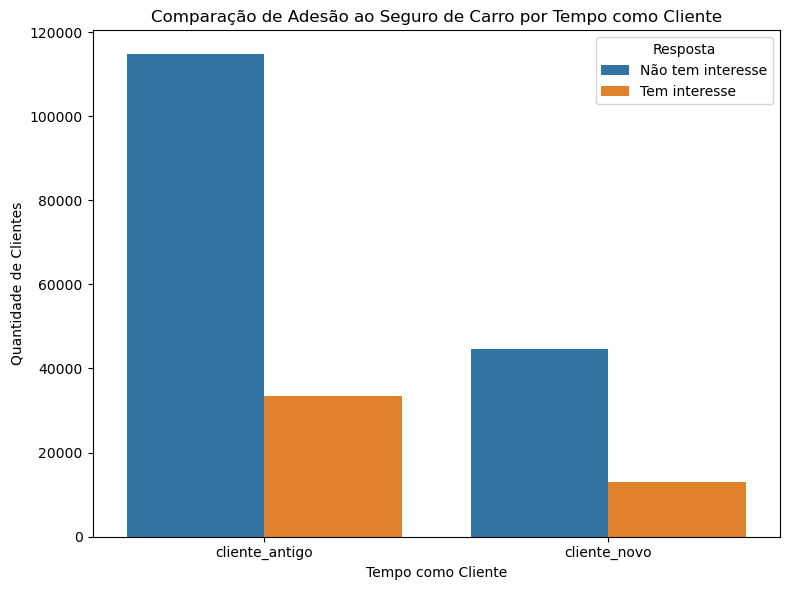

In [249]:
plt.figure(figsize=(8, 6))

sns.countplot(x='vintage', hue='response', data=df4)
plt.xlabel('Tempo como Cliente')
plt.ylabel('Quantidade de Clientes')
plt.title('Comparação de Adesão ao Seguro de Carro por Tempo como Cliente')
plt.legend(title='Resposta', labels=['Não tem interesse', 'Tem interesse'])

plt.tight_layout()
plt.show()


### H5 - Clientes que possuem carro que teve dano no passado deveriam aderir mais ao seguro de carro.
**True** 

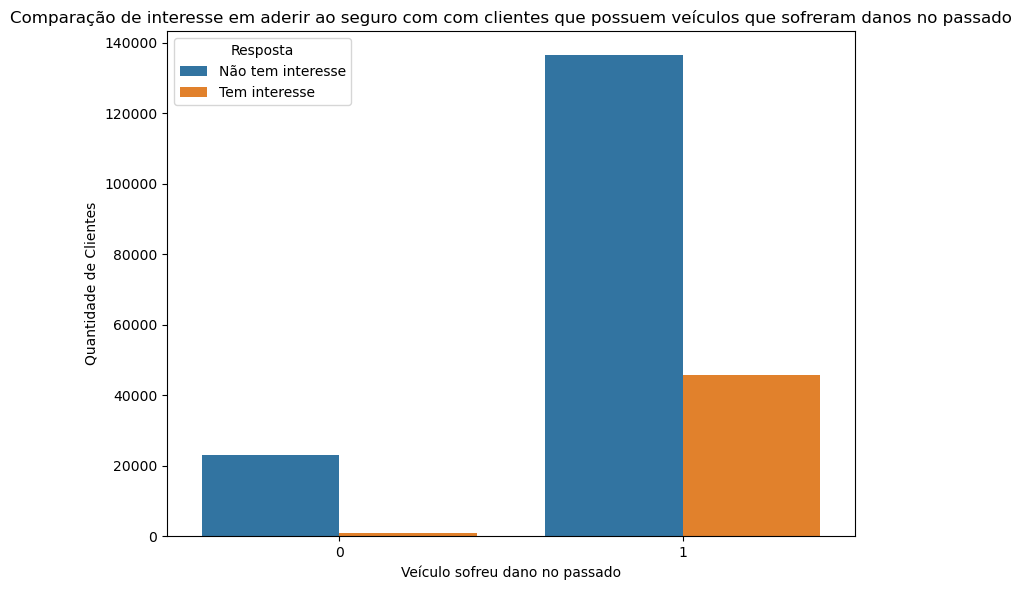

In [251]:
plt.figure(figsize=(8, 6))

sns.countplot(x='vehicle_damage', hue='response', data=df4)
plt.xlabel('Veículo sofreu dano no passado')
plt.ylabel('Quantidade de Clientes')
plt.title('Comparação de interesse em aderir ao seguro com com clientes que possuem veículos que sofreram danos no passado')
plt.legend(title='Resposta', labels=['Não tem interesse', 'Tem interesse'])

plt.tight_layout()
plt.show()

### H6 - Clientes que possuem carros mais novos deveriam aderir mais ao seguro de carro.
**False** Clientes com carros semi novos (mais de um ano) tem um interesse maior em aderir ao seguro de carro.

<Figure size 800x600 with 0 Axes>

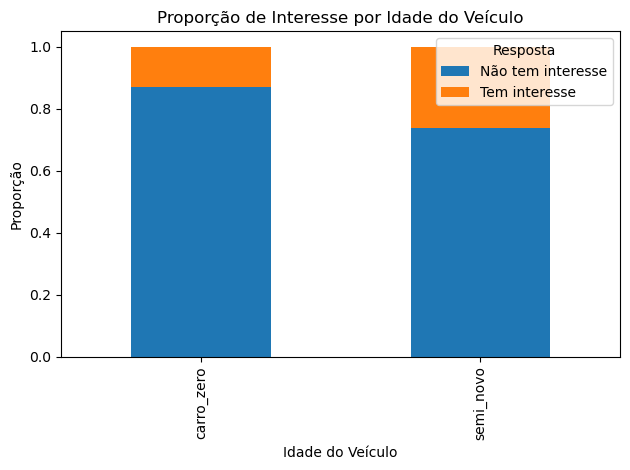

In [258]:
plt.figure(figsize=(8, 6))

# Agrupar os dados por idade do veículo e calcular a proporção de interesse
age_interest = df4.groupby(['vehicle_age', 'response']).size().unstack()
age_interest = age_interest.div(age_interest.sum(axis=1), axis=0)

# Plotar o gráfico de barra empilhada
age_interest.plot(kind='bar', stacked=True)

plt.xlabel('Idade do Veículo')
plt.ylabel('Proporção')
plt.title('Proporção de Interesse por Idade do Veículo')
plt.legend(title='Resposta', labels=['Não tem interesse', 'Tem interesse'])

plt.tight_layout()
plt.show()


### H7 - Clientes que já possuem seguro de automóvel deveriam aderir renovar o seguro.
**False** A maioria não tem interesse em continuar com o seguro no futuro.

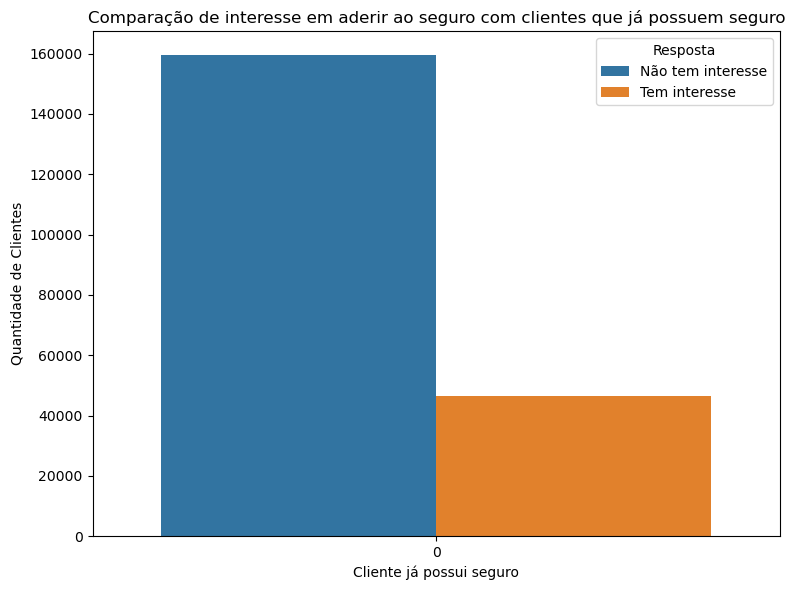

In [275]:
plt.figure(figsize=(8, 6))

df_interesse = df4[df4['response'] == 1]  # Filtrar apenas os clientes com interesse em aderir ao seguro
sns.countplot(x='previously_insured', data=df4, hue='response')
plt.xlabel('Cliente já possui seguro')
plt.ylabel('Quantidade de Clientes')
plt.title('Comparação de interesse em aderir ao seguro com clientes que já possuem seguro')
plt.legend(title='Resposta', labels=['Não tem interesse', 'Tem interesse'])

plt.tight_layout()
plt.show()

### H8 - Clientes que pagam prêmios maiores deveriam aderir mais ao seguro de carro.
**True**

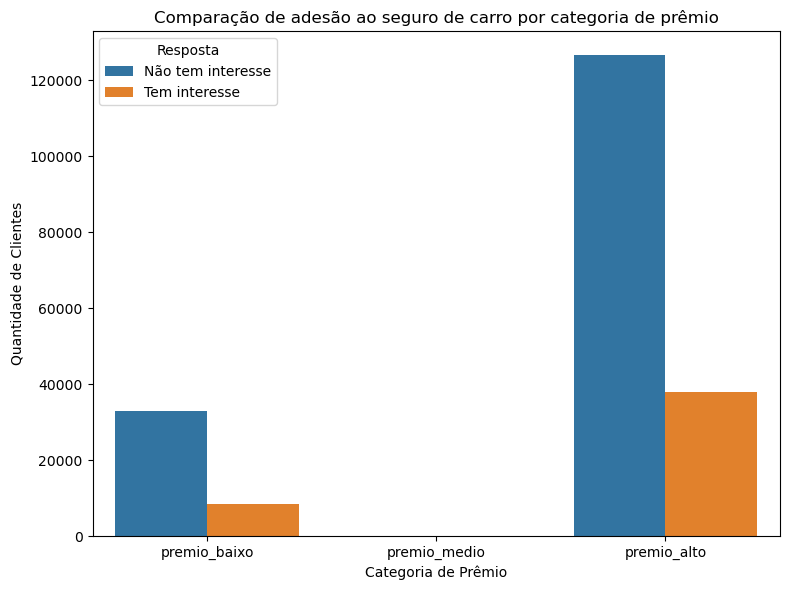

In [278]:
plt.figure(figsize=(8, 6))
sns.countplot(x='annual_premium', hue='response', data=df4, order=['premio_baixo', 'premio_medio', 'premio_alto'])
plt.xlabel('Categoria de Prêmio')
plt.ylabel('Quantidade de Clientes')
plt.title('Comparação de adesão ao seguro de carro por categoria de prêmio')
plt.legend(title='Resposta', labels=['Não tem interesse', 'Tem interesse'])
plt.tight_layout()
plt.show()
